In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sqlite3

In [4]:
amazon_df = pd.read_csv("amazon_xm5.csv")
walmart_df = pd.read_csv("walmart_xm5.csv")

conn = sqlite3.connect("reviews.db")

amazon_df.to_sql("amazon_reviews", conn, if_exists="replace", index=False)
walmart_df.to_sql("walmart_reviews", conn, if_exists="replace", index=False)

600

In [5]:
print(amazon_df.columns)
print(walmart_df.columns)

Index(['ASIN', 'Brand', 'HelpfulCounts', 'Images/0', 'Images/1', 'Images/2',
       'Images/3', 'Images/4', 'Images/5', 'Images/6', 'Images/7', 'Images/8',
       'Images/9', 'Images/10', 'Images/11', 'Images/12', 'Images/13',
       'PageUrl', 'ParentId', 'ProductLink', 'ProductTitle', 'ReviewContent',
       'ReviewDate', 'ReviewScore', 'ReviewTitle', 'Reviewer', 'Variant/0',
       'Verified'],
      dtype='object')
Index(['authorId', 'badges/0', 'badges/1', 'badges/2', 'externalSource',
       'itemType', 'negativeFeedback', 'positiveFeedback', 'productId',
       'productName', 'productUrl', 'rating', 'recommended', 'reviewId',
       'submissionTime', 'text', 'title', 'userNickname'],
      dtype='object')


In [6]:
amazon_query = """
SELECT 
    ReviewScore,
    ReviewTitle,
    ReviewContent
FROM amazon_reviews
"""

amazon_selected = pd.read_sql(amazon_query, conn)
amazon_selected.head()

,ReviewScore,ReviewTitle,ReviewContent
0,4.0,Sony xm5 vs bose qc ultra.,"Build QualityFor me, there's no question that ..."
1,2.0,Disappointed in build quality,The sound quality and noise cancelation was gr...
2,1.0,Design flow with hinge that leads to breakage,The issue with the hinge defect is covered ext...
3,5.0,Beautiful and the sound quality is amazing!,I just got these and the sound quality is incr...
4,5.0,"battery life seems low, just software updates ...","doesn't come with a charger, the cable that co..."


In [7]:
walmart_query = """
SELECT 
    rating, 
    title,
    text
FROM walmart_reviews
"""

walmart_selected = pd.read_sql(walmart_query, conn)
walmart_selected.head()

,rating,title,text
0,5,Better generation of headphones,Good headphones! Lighter than the previous gen...
1,5,Love the XM5s,I am not sure why I waited so long for these …...
2,5,Awesome Sounds!,"I bought these about a month ago, but we alrea..."
3,5,Flight Changing,Bought the XM5's a few weeks ago in preparatio...
4,5,A Sony convert,It's just over a week since I got these headph...


In [8]:
amazon_selected.rename({"ReviewScore":"rating", "ReviewTitle":"title", "ReviewContent":"text"}, axis=1, inplace=True)

In [9]:
amazon_selected.head()

,rating,title,text
0,4.0,Sony xm5 vs bose qc ultra.,"Build QualityFor me, there's no question that ..."
1,2.0,Disappointed in build quality,The sound quality and noise cancelation was gr...
2,1.0,Design flow with hinge that leads to breakage,The issue with the hinge defect is covered ext...
3,5.0,Beautiful and the sound quality is amazing!,I just got these and the sound quality is incr...
4,5.0,"battery life seems low, just software updates ...","doesn't come with a charger, the cable that co..."


In [10]:
combined_df = pd.concat([amazon_selected, walmart_selected], ignore_index=True)
combined_df

,rating,title,text
0,4.0,Sony xm5 vs bose qc ultra.,"Build QualityFor me, there's no question that ..."
1,2.0,Disappointed in build quality,The sound quality and noise cancelation was gr...
2,1.0,Design flow with hinge that leads to breakage,The issue with the hinge defect is covered ext...
3,5.0,Beautiful and the sound quality is amazing!,I just got these and the sound quality is incr...
4,5.0,"battery life seems low, just software updates ...","doesn't come with a charger, the cable that co..."
...,...,...,...
897,2.0,Totally inaccurate info from seller.,quality is great but the battery is probably o...
898,5.0,I can say good not excellent,Feature should have optimized more as some tim...
899,5.0,Love these.,Excellent headphones. Love the way it pairs wi...
900,2.0,Major disappointment.,Loved the XM threes but this is not the upgrad...


In [11]:
conn.close()

In [12]:
def combine_text(row):
    title = str(row["title"])
    text = str(row["text"])
    return title + ' ' + text

combined_df['combined_text'] = combined_df.apply(combine_text, axis=1)

combined_df.head()

,rating,title,text,combined_text
0,4.0,Sony xm5 vs bose qc ultra.,"Build QualityFor me, there's no question that ...",Sony xm5 vs bose qc ultra. Build QualityFor me...
1,2.0,Disappointed in build quality,The sound quality and noise cancelation was gr...,Disappointed in build quality The sound qualit...
2,1.0,Design flow with hinge that leads to breakage,The issue with the hinge defect is covered ext...,Design flow with hinge that leads to breakage ...
3,5.0,Beautiful and the sound quality is amazing!,I just got these and the sound quality is incr...,Beautiful and the sound quality is amazing! I ...
4,5.0,"battery life seems low, just software updates ...","doesn't come with a charger, the cable that co...","battery life seems low, just software updates ..."


In [13]:
combined_df["combined_text"] = combined_df["combined_text"].replace(r"^\s*$", "[EMPTY]", regex=True)


In [14]:
from langdetect import detect, DetectorFactory

# Set seed for consistent results
DetectorFactory.seed = 42

def detect_language(text):
    try:
        if text.strip():  # Ensure the text is not empty
            return detect(text)
        return "unknown"  # Handle empty strings
    except Exception as e:
        print(f"Error detecting language: {e} - Text: {text}")
        return "error"  # Return "error" if detection fails

In [15]:
# Using langdetect
combined_df["language"] = combined_df["combined_text"].apply(detect_language)

print(combined_df.head())

   rating                                              title  \
0     4.0                         Sony xm5 vs bose qc ultra.   
1     2.0                      Disappointed in build quality   
2     1.0      Design flow with hinge that leads to breakage   
3     5.0        Beautiful and the sound quality is amazing!   
4     5.0  battery life seems low, just software updates ...   

                                                text  \
0  Build QualityFor me, there's no question that ...   
1  The sound quality and noise cancelation was gr...   
2  The issue with the hinge defect is covered ext...   
3  I just got these and the sound quality is incr...   
4  doesn't come with a charger, the cable that co...   

                                       combined_text language  
0  Sony xm5 vs bose qc ultra. Build QualityFor me...       en  
1  Disappointed in build quality The sound qualit...       en  
2  Design flow with hinge that leads to breakage ...       en  
3  Beautiful and the s

In [16]:
combined_df["language"].value_counts()

language
en    891
es      8
af      1
tl      1
ca      1
Name: count, dtype: int64

Notice that only 11 reviews are non english. Given that this is just over 1% of our dataset, rather than translating them I will just drop these reviews (dont want to use the apis)

In [17]:
drop_rows = list(combined_df[combined_df.iloc[:,-1]!="en"].index)
combined_df.drop(combined_df.index[drop_rows], inplace = True)

In [18]:
combined_df

,rating,title,text,combined_text,language
0,4.0,Sony xm5 vs bose qc ultra.,"Build QualityFor me, there's no question that ...",Sony xm5 vs bose qc ultra. Build QualityFor me...,en
1,2.0,Disappointed in build quality,The sound quality and noise cancelation was gr...,Disappointed in build quality The sound qualit...,en
2,1.0,Design flow with hinge that leads to breakage,The issue with the hinge defect is covered ext...,Design flow with hinge that leads to breakage ...,en
3,5.0,Beautiful and the sound quality is amazing!,I just got these and the sound quality is incr...,Beautiful and the sound quality is amazing! I ...,en
4,5.0,"battery life seems low, just software updates ...","doesn't come with a charger, the cable that co...","battery life seems low, just software updates ...",en
...,...,...,...,...,...
897,2.0,Totally inaccurate info from seller.,quality is great but the battery is probably o...,Totally inaccurate info from seller. quality i...,en
898,5.0,I can say good not excellent,Feature should have optimized more as some tim...,I can say good not excellent Feature should ha...,en
899,5.0,Love these.,Excellent headphones. Love the way it pairs wi...,Love these. Excellent headphones. Love the way...,en
900,2.0,Major disappointment.,Loved the XM threes but this is not the upgrad...,Major disappointment. Loved the XM threes but ...,en


In [19]:
combined_df.reset_index(drop=True, inplace=True)
combined_df

,rating,title,text,combined_text,language
0,4.0,Sony xm5 vs bose qc ultra.,"Build QualityFor me, there's no question that ...",Sony xm5 vs bose qc ultra. Build QualityFor me...,en
1,2.0,Disappointed in build quality,The sound quality and noise cancelation was gr...,Disappointed in build quality The sound qualit...,en
2,1.0,Design flow with hinge that leads to breakage,The issue with the hinge defect is covered ext...,Design flow with hinge that leads to breakage ...,en
3,5.0,Beautiful and the sound quality is amazing!,I just got these and the sound quality is incr...,Beautiful and the sound quality is amazing! I ...,en
4,5.0,"battery life seems low, just software updates ...","doesn't come with a charger, the cable that co...","battery life seems low, just software updates ...",en
...,...,...,...,...,...
886,2.0,Totally inaccurate info from seller.,quality is great but the battery is probably o...,Totally inaccurate info from seller. quality i...,en
887,5.0,I can say good not excellent,Feature should have optimized more as some tim...,I can say good not excellent Feature should ha...,en
888,5.0,Love these.,Excellent headphones. Love the way it pairs wi...,Love these. Excellent headphones. Love the way...,en
889,2.0,Major disappointment.,Loved the XM threes but this is not the upgrad...,Major disappointment. Loved the XM threes but ...,en


[4221, 4406, 4538, 4685, 4718, 4815, 4946, 5238, 5930, 6748] [16, 22, 23, 23, 25, 25, 27, 29, 30, 30]


Text(0, 0.5, 'Count')

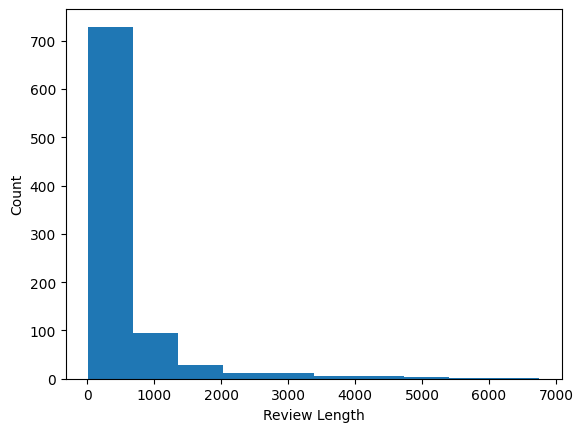

In [20]:
len_reviews_combined = combined_df["combined_text"].str.len()
len_reviews_combined = sorted(len_reviews_combined)
print(len_reviews_combined[-10:], len_reviews_combined[:10])

plt.hist(len_reviews_combined)
plt.xlabel('Review Length')
plt.ylabel('Count')

In [21]:
combined_df["length"] = combined_df["combined_text"].str.len()
shorter_df = combined_df[combined_df["length"] < 500]
shorter_df

,rating,title,text,combined_text,language,length
1,2.0,Disappointed in build quality,The sound quality and noise cancelation was gr...,Disappointed in build quality The sound qualit...,en,190
2,1.0,Design flow with hinge that leads to breakage,The issue with the hinge defect is covered ext...,Design flow with hinge that leads to breakage ...,en,246
4,5.0,"battery life seems low, just software updates ...","doesn't come with a charger, the cable that co...","battery life seems low, just software updates ...",en,443
5,1.0,Only lasted 6 months before breaking,"Sound quality is great, but they only lasted 6...",Only lasted 6 months before breaking Sound qua...,en,311
6,5.0,Perfect.,"Better than my Airpods Pros, Better than my Sa...","Perfect. Better than my Airpods Pros, Better t...",en,435
...,...,...,...,...,...,...
886,2.0,Totally inaccurate info from seller.,quality is great but the battery is probably o...,Totally inaccurate info from seller. quality i...,en,154
887,5.0,I can say good not excellent,Feature should have optimized more as some tim...,I can say good not excellent Feature should ha...,en,176
888,5.0,Love these.,Excellent headphones. Love the way it pairs wi...,Love these. Excellent headphones. Love the way...,en,121
889,2.0,Major disappointment.,Loved the XM threes but this is not the upgrad...,Major disappointment. Loved the XM threes but ...,en,145


We're going to split the reviews into positive and negative, so that we can segment the successful purchases while also noting the negative aspects/features. We will consider 3+ stars positive, since 3 stars usually means 'fine' or 'okay' rather than a negative review

In [22]:
positives = shorter_df[shorter_df["rating"] >= 3.0]
positives.reset_index(drop=True, inplace=True)
print(len(positives))
positives.head()

535


,rating,title,text,combined_text,language,length
0,5.0,"battery life seems low, just software updates ...","doesn't come with a charger, the cable that co...","battery life seems low, just software updates ...",en,443
1,5.0,Perfect.,"Better than my Airpods Pros, Better than my Sa...","Perfect. Better than my Airpods Pros, Better t...",en,435
2,5.0,Perfect headphones,These Sony headphones are EPIC. Sound is great...,Perfect headphones These Sony headphones are E...,en,442
3,5.0,Great noise canceling great sound,The audio quality of these headphones is excep...,Great noise canceling great sound The audio qu...,en,446
4,5.0,The best!!!,"Sony is SONY, no more words.","The best!!! Sony is SONY, no more words.",en,40


In [23]:
negatives = shorter_df[shorter_df["rating"] < 3.0]
negatives.reset_index(drop=True, inplace=True)
print(len(negatives))
negatives.head()

112


,rating,title,text,combined_text,language,length
0,2.0,Disappointed in build quality,The sound quality and noise cancelation was gr...,Disappointed in build quality The sound qualit...,en,190
1,1.0,Design flow with hinge that leads to breakage,The issue with the hinge defect is covered ext...,Design flow with hinge that leads to breakage ...,en,246
2,1.0,Only lasted 6 months before breaking,"Sound quality is great, but they only lasted 6...",Only lasted 6 months before breaking Sound qua...,en,311
3,1.0,received wrong item in the box and Amazon will...,None,received wrong item in the box and Amazon will...,en,72
4,1.0,NOT NEW!,I received used and dirty headphones in a stai...,NOT NEW! I received used and dirty headphones ...,en,176


## Segmenting the Positive Reviews

In [24]:
print(positives["combined_text"].str.len().max())
print(positives["combined_text"].str.len().min())

497
16


In [25]:
len_reviews = positives["combined_text"].str.len()
len_reviews = sorted(len_reviews)
print(len_reviews[-5:], len_reviews[:5])

[490, 491, 494, 495, 497] [16, 22, 23, 23, 25]


Text(0, 0.5, 'Count')

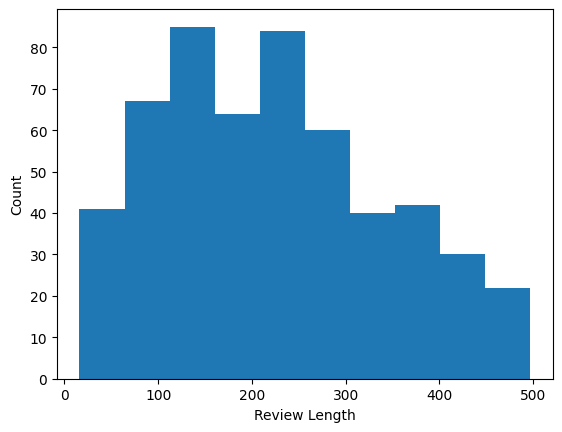

In [26]:
plt.hist(len_reviews)
plt.xlabel('Review Length')
plt.ylabel('Count')

Notice that most of our documents/texts are under 1000 characters (before preprocessing and text cleaning). Methods like PCA may lose valuable information from the text.

In [27]:
import re
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

# Define custom stopwords
custom_stopwords = list(text.ENGLISH_STOP_WORDS) + ["headphones", "sony", "product", "review", "bose", "sennheiser", "xm", "xms",
                                                    "amazon", "earbuds", "earphones", "use", "using", "item", "music",
                                                    "airpods", "airpod", "beats", "bowers wilkins", "jbl", "xm3", "xm3s",
                                                    "xm4", "xm4s", "bowers", "wilkins", "good", "packaging", "package", "sound",
                                                    "qc", "50", "sound", "oder", "deliver"]


tfidf = TfidfVectorizer(
    stop_words=custom_stopwords,
    max_features=6000,
    ngram_range=(1, 3),  # Capture unigrams and bigrams
    use_idf=True,
)

# Apply TF-IDF to your tokenized text
tfidf_matrix = tfidf.fit_transform(combined_df["combined_text"])

svd = TruncatedSVD(n_components=200, random_state=42)

reduced_matrix = svd.fit_transform(tfidf_matrix)

print(f"Shape of reduced matrix: {reduced_matrix.shape}")


Shape of reduced matrix: (891, 200)


In [28]:
var_explained = svd.explained_variance_ratio_.sum()
var_explained

np.float64(0.5379058887219053)

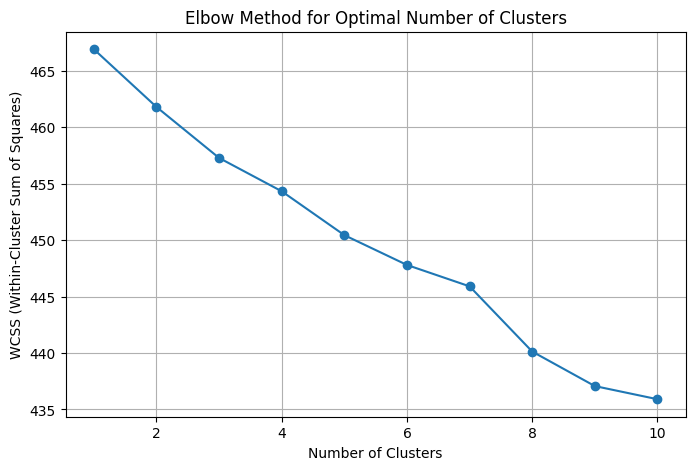

In [29]:
from sklearn.cluster import KMeans

# Step 1: Iterate over a range of cluster numbers
wcss = []
range_clusters = range(1, 11)  # Test from 1 to 10 clusters

for k in range_clusters:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(reduced_matrix)
    wcss.append(kmeans.inertia_)  # Inertia: Sum of squared distances to nearest cluster center

# Step 2: Plot the WCSS values
plt.figure(figsize=(8, 5))
plt.plot(range_clusters, wcss, marker='o')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS (Within-Cluster Sum of Squares)')
plt.grid(True)
plt.show()

Using the elbow method and many iterations of hyperparams for vectorization and svd, we can see that the data does not clusters properly into any # of clusters (no elbow). To find segments, we will use the predetermined cluster of star rating to find topics that are positive, and some which are good but can use improvement (3 stars).

In [91]:
reviews_3 = positives[positives["rating"] == 3]["combined_text"]
reviews_4 = positives[positives["rating"] == 4]["combined_text"]
reviews_5 = positives[positives["rating"] == 5]["combined_text"]

In [92]:
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = re.sub(r"[^a-zA-Z\s]", "", text.lower())  # Remove non-alphabetic characters
    tokens = text.split()
    return " ".join([lemmatizer.lemmatize(word) for word in tokens if word not in custom_stopwords])

reviews_3 = reviews_3.apply(clean_text)
reviews_4 = reviews_4.apply(clean_text)
reviews_5 = reviews_5.apply(clean_text)

In [93]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer_3 = CountVectorizer(max_features=3500, stop_words=custom_stopwords, ngram_range=(1,3))
matrix_3 = vectorizer_3.fit_transform(reviews_3)

vectorizer_4 = CountVectorizer(max_features=3500, stop_words=custom_stopwords, ngram_range=(1,3))
matrix_4 = vectorizer_4.fit_transform(reviews_4)

vectorizer_5 = CountVectorizer(max_features=3500, stop_words=custom_stopwords, ngram_range=(1,3))
matrix_5 = vectorizer_5.fit_transform(reviews_5)



In [94]:
from sklearn.decomposition import LatentDirichletAllocation

lda_3 = LatentDirichletAllocation(n_components=6, random_state=42)
lda_3.fit(matrix_3)

lda_4 = LatentDirichletAllocation(n_components=6, random_state=42)
lda_4.fit(matrix_4)

lda_5 = LatentDirichletAllocation(n_components=6, random_state=42)
lda_5.fit(matrix_5)


LatentDirichletAllocation(n_components=6, random_state=42)

In [96]:
def print_topics(model, feature_names, n_top_words=10):
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topic {topic_idx}:")
        print(", ".join([feature_names[i] for i in topic.argsort()[-n_top_words:]]))

print("3-Star Topics:")
print_topics(lda_3, vectorizer_3.get_feature_names_out())


3-Star Topics:
Topic 0:
plus plan, protection plus plan, protection, plus, protection plus, accident, noise, great, broke, bought
Topic 1:
great, like, loud price, eq, volume, device, price, max, bought, loud
Topic 2:
great, bluetooth, time, theyre, headset, app, work, nice, just, need
Topic 3:
easily, break easily, dont, poorly, ok dont, pause, feel, ok, head, just
Topic 4:
work, need, really, doesnt, disappointed, amazing, tight, head, quality, great
Topic 5:
got, dont, price, new, noise, wear, better, ear, need, great


In [97]:
print("4-Star Topics:")
print_topics(lda_4, vectorizer_4.get_feature_names_out())

4-Star Topics:
Topic 0:
issue, thing, reason, anc, really, noise cancellation, cancellation, quality, noise, great
Topic 1:
ear, headband, comfortable, dont, warm, time, noise cancelling, cancelling, great, noise
Topic 2:
month ago, bought, quality, month, ago, feature, cancelling, noise cancelling, noise, great
Topic 3:
bit, happy, perfect, comfortable, ear, great, solid, time, anc, quality
Topic 4:
device, dont, hour, life, battery life, battery, quality, day, like, great
Topic 5:
connect, doe, change, comfortable, love, device, work, app, great, quality


In [106]:
print("5-star topics")
print_topics(lda_5, vectorizer_5.get_feature_names_out())

5-star topics
Topic 0:
ago, price, wear, excellent, better, comfortable, best, great, noise, quality
Topic 1:
price, best, love, bought, work, feature, better, noise, quality, great
Topic 2:
happy, excellent, amazing, feature, noise cancelling, cancelling, love, noise, great, quality
Topic 3:
app, canceling, love, really, bought, quality, noise, amazing, great, best
Topic 4:
cancellation, ive, quality, comfortable, excellent, best, great, noise cancelling, cancelling, noise
Topic 5:
work, best, cancelling, noise cancelling, comfortable, quality, amazing, ive, noise, great


## Insights

### 3-Star Reviews
The 3-star topics highlight pricing concerns, durability issues, and basic functionality. Many mention "protection plans," "break easily," and "accident," indicating longevity worries. There are also price mentions like "loud price" and "new price." While some customers acknowledge decent sound quality and noise cancellation, concerns about durability and value dominate.

The 3-star reviews suggest customers value affordability and basic noise cancellation but are frustrated by durability issues and pricing.

#### Customer Persona - The Budget-Conscious User
- Profile: Price-sensitive buyers looking for functional, durable headphones.  
- Needs: Affordable, reliable headphones with decent sound.  
- Frustrations: Durability concerns, pricing, and longevity.  
- Motivations: A good deal or warranty protection for long-term use.  

---

### 4-Star Reviews
The 4-star topics highlight satisfaction with ANC, comfort, and battery life but mention minor usability concerns. Customers appreciate "noise cancelling," "quality," and "anc" but note issues like warmth from the headband, battery life, and occasional connectivity problems. Price is less of a concern than in 3-star reviews, but usability refinements are expected.

The 4-star reviews suggest customers are satisfied with ANC and comfort but want refinements in battery life, connectivity, and usability.

#### Customer Persona - The Enthusiastic Upgrader
- Profile: Upgraders who value ANC, sound, and comfort.  
- Needs: Strong ANC, comfortable fit, long battery life.  
- Frustrations: Warm headband, occasional connectivity issues, battery performance.  
- Motivations: A refined user experience that justifies the upgrade.  

---

### 5-Star Reviews
The 5-star topics are overwhelmingly positive, with frequent mentions of "excellent," "best," "amazing," and "love." Customers praise noise cancellation, comfort, and sound quality, with minimal complaints. "App," "cancelling," "wear," and "battery life" are all mentioned positively, suggesting a seamless user experience.

The 5-star reviews indicate customers are fully satisfied, viewing the headphones as a premium product.

#### Customer Persona - The Loyal Audiophile
- Profile: Highly satisfied users prioritizing premium sound and ANC.  
- Needs: High-end ANC, top-tier sound, and long-term comfort.  
- Frustrations: None or negligible.  
- Motivations: Seeking an immersive, high-performance listening experience.  

---

#### Key Takeaways
- 3-Star Buyers: Price-sensitive, concerned about durability, expect better value.  
- 4-Star Buyers: Happy with ANC and comfort but expect usability refinements.  
- 5-Star Buyers: Fully satisfied, see the product as premium, few complaints.  


## Negative Reviews

In [78]:
negatives[negatives["rating"] < 2]

,rating,title,text,combined_text,language,length
1,1.0,Design flow with hinge that leads to breakage,The issue with the hinge defect is covered ext...,Design flow with hinge that leads to breakage ...,en,246
2,1.0,Only lasted 6 months before breaking,"Sound quality is great, but they only lasted 6...",Only lasted 6 months before breaking Sound qua...,en,311
3,1.0,received wrong item in the box and Amazon will...,None,received wrong item in the box and Amazon will...,en,72
4,1.0,NOT NEW!,I received used and dirty headphones in a stai...,NOT NEW! I received used and dirty headphones ...,en,176
6,1.0,Gross!!!,The package is covered in sticky gunk! For as ...,Gross!!! The package is covered in sticky gunk...,en,116
...,...,...,...,...,...,...
97,1.0,None,I haven't received my item yet,None I haven't received my item yet,en,35
98,1.0,I did not like the product. The mic quality is...,I did not like the product. The mic quality is...,I did not like the product. The mic quality is...,en,101
99,1.0,None,I haven't received my item yet,None I haven't received my item yet,en,35
108,1.0,Bad headset,I tried to connect to two devices and it didn'...,Bad headset I tried to connect to two devices ...,en,146


In [99]:
reviews_1 = negatives[negatives["rating"] < 2]["combined_text"]
reviews_2 = negatives[negatives["rating"] == 2]["combined_text"]

reviews_1 = reviews_1.apply(clean_text)
reviews_2 = reviews_2.apply(clean_text)

vectorizer_1 = CountVectorizer(max_features=3500, stop_words=custom_stopwords, ngram_range=(1,3))
matrix_1 = vectorizer_1.fit_transform(reviews_1)

vectorizer_2 = CountVectorizer(max_features=3500, stop_words=custom_stopwords, ngram_range=(1,3))
matrix_2 = vectorizer_2.fit_transform(reviews_2)

In [100]:
matrix_1

<Compressed Sparse Row sparse matrix of dtype 'int64'
	with 3900 stored elements and shape (80, 3123)>

In [101]:
lda_1 = LatentDirichletAllocation(n_components=6, random_state=42)
lda_1.fit(matrix_1)

lda_2 = LatentDirichletAllocation(n_components=6, random_state=42)
lda_2.fit(matrix_2)

LatentDirichletAllocation(n_components=6, random_state=42)

In [103]:
print("1-star reviews")
print_topics(lda_1, vectorizer_1.get_feature_names_out())

Topic 0:
dirty, thought, new, head, didnt, disappointed, noise, received, damaged, used
Topic 1:
doesnt, way, headphone, head, cover, warranty, left, broke, month, year
Topic 2:
arrived, year, warranty, money, head, quality, month, break, dont, anc
Topic 3:
ear, work, having, month, connect, samsung tv, issue, bought, samsung, tv
Topic 4:
help, time, device, buy, just, piece, broke, plastic, great, month
Topic 5:
just, right ear, app, right, ear, work, stopped working, working, stopped, pair


In [105]:
print("2-star reviews")
print_topics(lda_2, vectorizer_2.get_feature_names_out())

2-star reviews
Topic 0:
excellent, quality quality, ear, highly, head, audio, cause, wear, experience, quality
Topic 1:
bad engineered, number, engineered, disappointed, build, noise, quality, im, great, bad
Topic 2:
like, great noise, nice, tried, disappointment, overall, broke, broke month, month, quality
Topic 3:
shallow, great, just, month, cup, noise cancelling, cancelling, ear, noise, anc
Topic 4:
software, extremely, hinge, month, better, app, device, pair, firmware, issue
Topic 5:
great, mode, just, software, time, noise cancelling, cancelling, phone, randomly, noise
